In [1]:
import numpy as np
import matplotlib.pyplot as plt

from propagators import propagator_fresnel

In [2]:
N = 512
R = 50

y, x = np.indices((N,N))
y = y - N//2
x = x - N//2
wavefront = np.where(x**2 + y**2 < R**2,1,0)
wavefront = wavefront*np.exp(1j*wavefront)

# fig, ax = plt.subplots()
# ax.imshow(mask)

20.0
IR preferred 781.25
IR preferred 781.25
IR preferred 781.25
IR preferred 781.25
1.953125e-06 < Pxl = 5e-08 < 1.0279605263157895e-07  ?


Text(0.5, 1.0, 'Fresnel 2step')

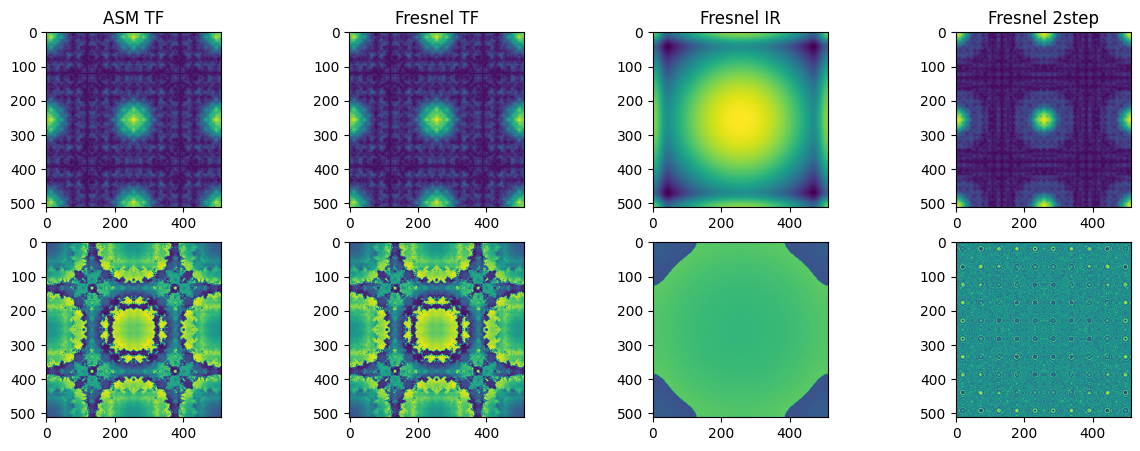

In [31]:
wavelength = 10e-10
pixel_size = 50e-9
sample_to_detector_distance = 1
detector_pixel_size = pixel_size*20
print(detector_pixel_size/pixel_size)

ASM_TF = propagator_fresnel(wavefront,wavelength,pixel_size,sample_to_detector_distance,method='ASM_TF')
fresnel_TF = propagator_fresnel(wavefront,wavelength,pixel_size,sample_to_detector_distance,method='fresnel_TF')
fresnel_IR = propagator_fresnel(wavefront,wavelength,pixel_size,sample_to_detector_distance,method='fresnel_IR')
fresnel_2step = propagator_fresnel(wavefront,wavelength,pixel_size,sample_to_detector_distance,detector_pixel_size=detector_pixel_size,method='fresnel_2step_magnification')

fig, ax = plt.subplots(2,4,dpi=100,figsize=(15,5))
ax[0,0].imshow(np.abs(ASM_TF))
ax[1,0].imshow(np.angle(ASM_TF))
ax[0,0].set_title('ASM TF')
ax[0,1].imshow(np.abs(fresnel_TF))
ax[1,1].imshow(np.angle(fresnel_TF))
ax[0,1].set_title('Fresnel TF')
ax[0,2].imshow(np.abs(fresnel_IR))
ax[1,2].imshow(np.angle(fresnel_IR))
ax[0,2].set_title('Fresnel IR')
ax[0,3].imshow(np.abs(fresnel_2step))
ax[1,3].imshow(np.angle(fresnel_2step))
ax[0,3].set_title('Fresnel 2step')

In [19]:
import scipy
import numpy as np
import matplotlib.pyplot as plt

def diffraction_square_apperture(x,y,distance,wavelength, half_width):
    fresnel_number = half_width**2/(distance*wavelength)
    a1 = -np.sqrt(2)*(np.sqrt(fresnel_number)+x/np.sqrt(distance*wavelength))
    a2 = np.sqrt(2)*(np.sqrt(fresnel_number)-x/np.sqrt(distance*wavelength))
    b1 = -np.sqrt(2)*(np.sqrt(fresnel_number)+y/np.sqrt(distance*wavelength))
    b2 = np.sqrt(2)*(np.sqrt(fresnel_number)-y/np.sqrt(distance*wavelength))

    Sa1,Ca1 = scipy.special.fresnel(a1)
    Sa2,Ca2 = scipy.special.fresnel(a2)
    Sb1,Cb1 = scipy.special.fresnel(b1)
    Sb2,Cb2 = scipy.special.fresnel(b2)

    return np.exp(1j*2*np.pi/wavelength*distance)/(2*1j)*((Ca2-Ca1)+1j*(Sa2-Sa1))*((Cb2-Cb1)+1j*(Sb2-Sb1)) # equation 4.46, Goodman, Introduction to Fourier Optics

def create_square_apertude(N,pixel,half_width):
    Y, X = np.indices((N,N))
    Y = (Y - N//2)*pixel
    X = (X - N//2)*pixel
    aperture = np.where( np.abs(X) > half_width, 0, np.where(np.abs(Y) > half_width,0,1))
    return aperture, X, Y

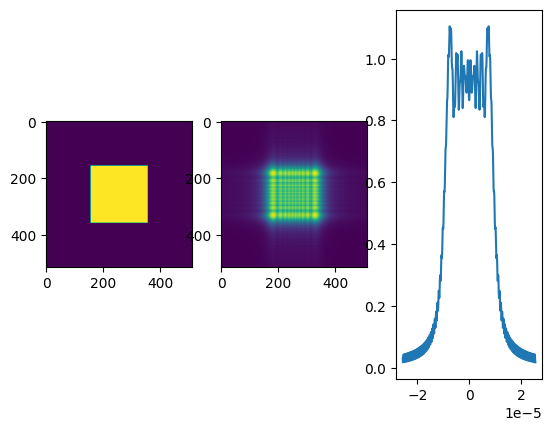

In [50]:
N = 512
pixel = 100e-9
half_width = 10e-6
distance = 1e-1
wavelength = 1e-10

aperture, X, Y = create_square_apertude(N,pixel,half_width)
diffracted = diffraction_square_apperture(X,Y,distance,wavelength, half_width)

fig, ax = plt.subplots(1,3)
ax[0].imshow(aperture)
ax[1].imshow(np.abs(diffracted))
ax[2].plot(X[diffracted.shape[0]//2,:],np.abs(diffracted)[diffracted.shape[0]//2,:])